This script tests the trained Gaussian process regression model on the month of June on the 10 intersections on which the model was trained. Thus, this script tests the model's gap-filling performance, since the model was trained using data sampled uniformly from May and July.

In [1]:
from __future__ import print_function
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
warnings.filterwarnings("ignore")

In [2]:
#%% Validation in terms of time: gap-filling
filename = 'gprPedsMdl.pickle'
gprPedsMdl = pickle.load(open(filename, 'rb'))

filename = 'gprCycsMdl.pickle'
gprCycsMdl = pickle.load(open(filename, 'rb'))

filename = 'PedestriansData.sav'
Pedestrians = pickle.load(open(filename, 'rb'))

filename = 'CyclistsData.sav'
Cyclists = pickle.load(open(filename, 'rb'))

filename = 'testInts.sav'
testInts = pickle.load(open(filename, 'rb')) # Hold-out intersection IDs

testInts represents the hold-out intersections, thus the actual trained intersections are recovered as below:

In [3]:
#Extracting the intersections used for training
allInts = list(np.arange(0,14)) #all intersections
trainInts = list(set(allInts) - set(testInts)) #trained intersections

Pedestrians and traffic data are collected together in a list as below in order to separately test their performance:

In [4]:
RoadUser = ['Pedestrians', 'Cyclists']

trafficData = [Pedestrians, Cyclists]

gprMdls = [gprPedsMdl, gprCycsMdl] #Gaussian process regression models

Evaluating the performance for each of the 10 intersections on the month of June, for pedestrians and cylists

RMSE: 282.42212053354933
R_Squared: 0.0966538005431874


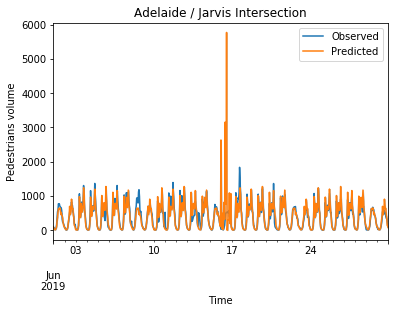

RMSE: 247.428655511736
R_Squared: -2.252114486542703


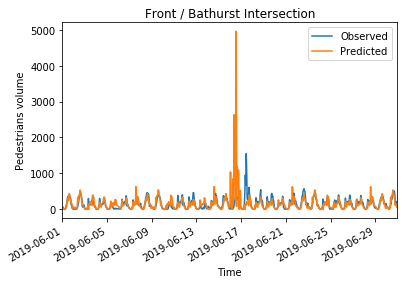

RMSE: 420.0721204162149
R_Squared: 0.7481246290558418


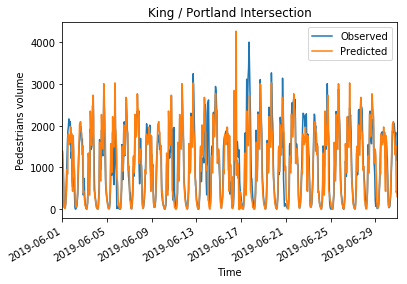

RMSE: 1169.7963533595637
R_Squared: 0.703827281376991


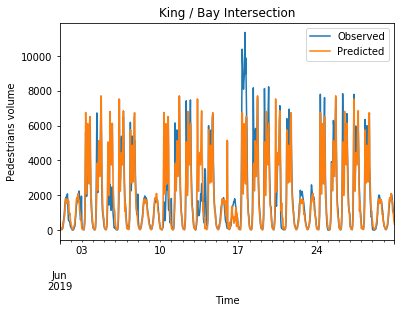

RMSE: 643.976262286809
R_Squared: 0.8449547884998607


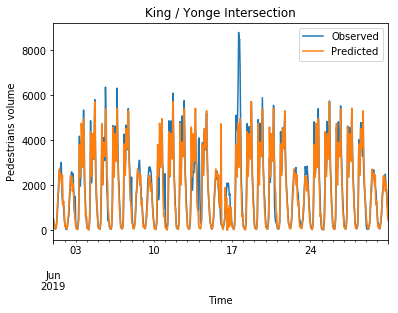

RMSE: 330.4953311151141
R_Squared: 0.6805593655363181


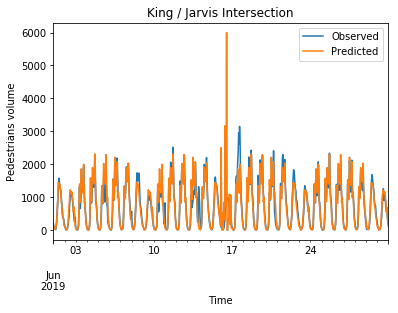

RMSE: 300.16356227368595
R_Squared: 0.9065089435161003


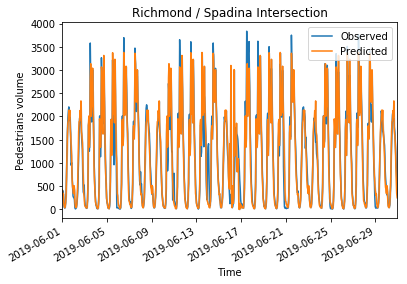

RMSE: 964.1000913344584
R_Squared: 0.6294014895123315


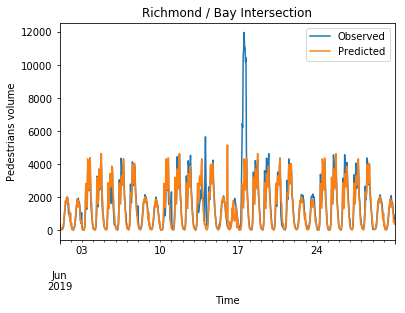

RMSE: 314.441840900972
R_Squared: 0.6288385460593531


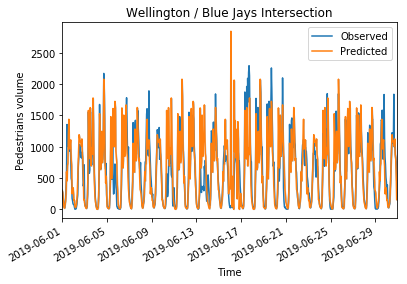

RMSE: 640.776518446556
R_Squared: 0.7949020430874604


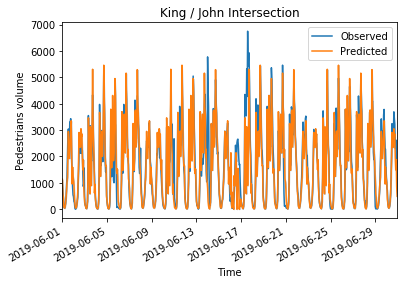

RMSE: 21.92193943453518
R_Squared: -0.39005068724353453


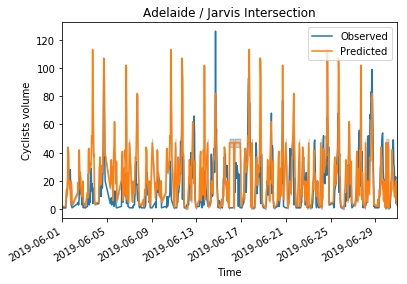

RMSE: 17.176619560960905
R_Squared: -0.4902396759411318


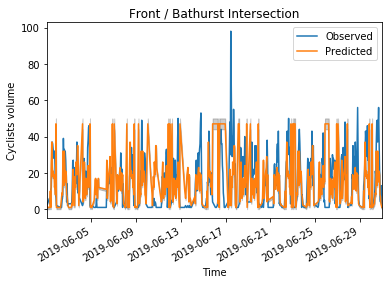

RMSE: 37.72609600961624
R_Squared: 0.5489222104633922


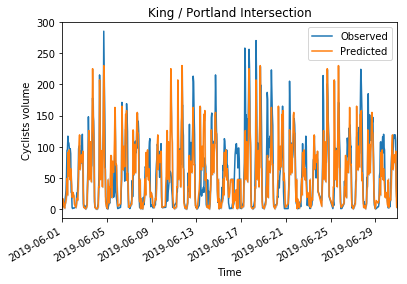

RMSE: 29.853368688428517
R_Squared: 0.49055582521770674


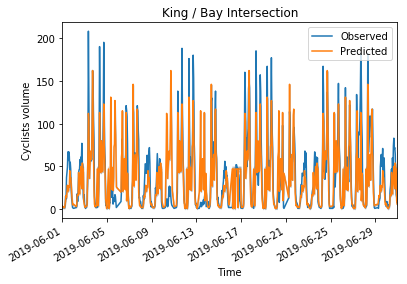

RMSE: 33.94688849763252
R_Squared: 0.6172100007012236


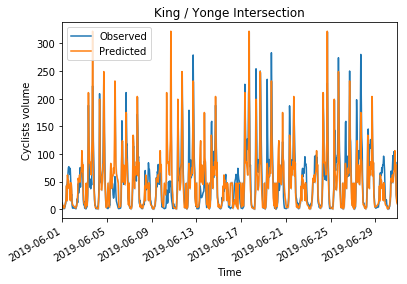

RMSE: 27.88229751329476
R_Squared: 0.6850070479696654


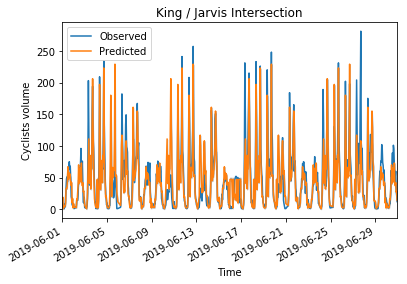

RMSE: 35.042858427677864
R_Squared: -0.6511291565736075


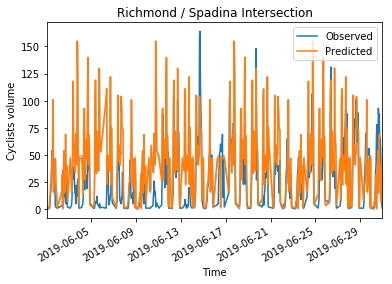

RMSE: 49.27181017778309
R_Squared: 0.5787037818440983


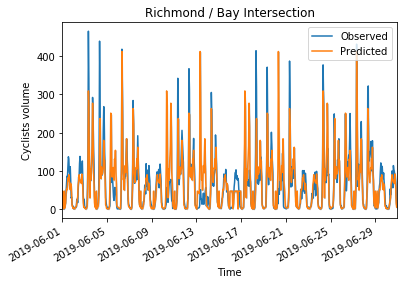

RMSE: 14.97967642106672
R_Squared: 0.19846824495865967


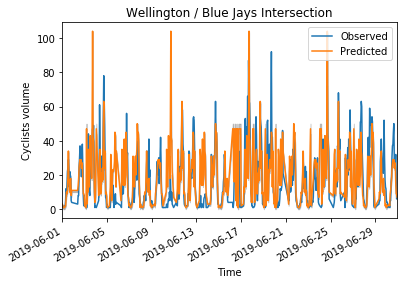

RMSE: 33.668875011802186
R_Squared: 0.593322214210477


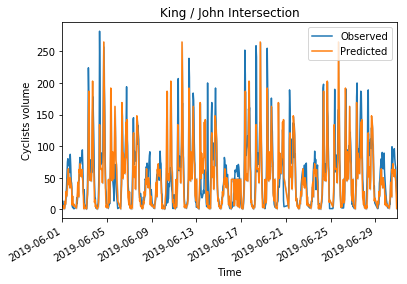

In [5]:
for j in range(2):
    
    gprMdl = gprMdls[j] #Selecting Gaussian process regression model 
    #for pedestrian or cyclists
    
    testData = trafficData[j]    
    
    for k in trainInts:
        
        testTraffic = testData[k];
        
        IntersectionName = testTraffic['IntName'][0]
        
        #Evaluating the hold-out set on the month of June for which 
        #the intersections were not trained for gap-filling
        
        testStart = pd.to_datetime('2019-06-01 00:00:00');
        testEnd = pd.to_datetime('2019-06-30 23:00:00');
        
        testTraffic = testTraffic[testStart: testEnd]
            
        testTraffic = testTraffic.dropna()
        
        X_test = testTraffic[['Hour','DayOfWeek','isHoliday','lat','lng']];
        
        y_test = testTraffic['volume']
        
        yPred, yStd = gprMdl.predict(X_test, return_std = True)
        yPred = yPred.astype('int'); yPred[yPred<0]=0
        
        yPred = pd.DataFrame(yPred, columns =['forecast']); 
        yPred.index = y_test.index; yPred = yPred['forecast'];
        
        print('RMSE: '+str(np.sqrt(np.mean((yPred.values - y_test.values)**2))))
        print('R_Squared: '+str(gprMdl.score(X_test, y_test)))
        
        #Plus/minus 3 times the standard deviation is used in order to show the 99.7% confidence bound 
        #of the predictions
        yLow = yPred - 3*yStd; yLow = yLow.astype('int'); yLow[yLow<0]=0
        yHigh = yPred + 3*yStd; yHigh = yHigh.astype('int');

        #Plotting for the month of June               
        plt.figure(j+k+1)
        ax = y_test.plot(label = 'Observed')
        yPred.plot(ax = ax, label = 'Predicted')
        ax.fill_between(y_test.index,
                            yLow,
                            yHigh, color='k', alpha=.2)
        ax.set_xlabel('Time')
        ax.set_ylabel(RoadUser[j]+ ' volume')
        ax.set_title(IntersectionName+ ' Intersection')
        plt.legend()
        plt.show()